In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Preprocessing

Accuracy: 0.7715, Precision: 0.7830, Recall: 0.7715, F1-score: 0.7562


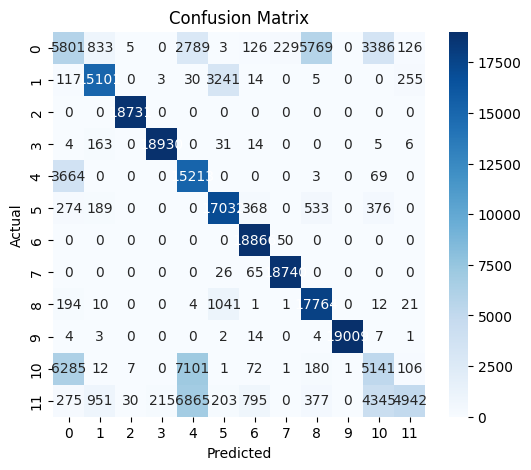

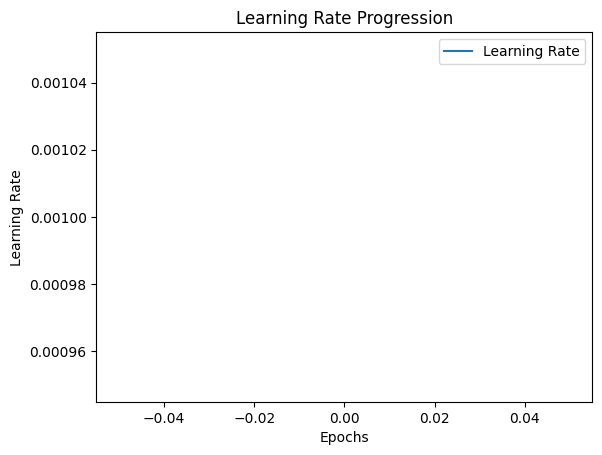

Model saved as student_model.pkl


In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import pickle
# Load dataset
data = pd.read_csv('RT_IOT2022.csv')

label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])


X = data.drop(columns=['Attack_type'])
y = data['Attack_type']

# Encode categorical labels
y = LabelEncoder().fit_transform(y)

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Define Teacher Model
class TeacherModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(TeacherModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# Define Student Model
class StudentModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(StudentModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, num_classes)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# Training configurations
input_dim = X_train.shape[1]
num_classes = len(set(y))  # Dynamically determine number of classes
teacher = TeacherModel(input_dim, num_classes)
student = StudentModel(input_dim, num_classes)

criterion = nn.CrossEntropyLoss()
distillation_criterion = nn.KLDivLoss(reduction='batchmean')
optimizer_teacher = optim.Adam(teacher.parameters(), lr=0.001)
optimizer_student = optim.Adam(student.parameters(), lr=0.001)

def train_teacher(model, optimizer, criterion, X_train, y_train, epochs=50):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

train_teacher(teacher, optimizer_teacher, criterion, X_train_tensor, y_train_tensor)

# Knowledge Distillation
alpha = 0.5
temperature = 3.0

def train_student(teacher, student, optimizer, X_train, y_train, epochs=40):
    teacher.eval()
    student.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        student_outputs = student(X_train)
        teacher_outputs = teacher(X_train).detach()
        loss = (alpha * distillation_criterion(F.log_softmax(student_outputs/temperature, dim=1), F.softmax(teacher_outputs/temperature, dim=1))) + ((1 - alpha) * criterion(student_outputs, y_train))
        loss.backward()
        optimizer.step()

train_student(teacher, student, optimizer_student, X_train_tensor, y_train_tensor)

# Evaluation
def evaluate(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        _, predictions = torch.max(outputs, 1)
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average='weighted')
    recall = recall_score(y_test, predictions, average='weighted')
    f1 = f1_score(y_test, predictions, average='weighted')
    cm = confusion_matrix(y_test, predictions)
    return accuracy, precision, recall, f1, cm

accuracy, precision, recall, f1, cm = evaluate(student, X_test_tensor, y_test_tensor)
print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}')

# Confusion Matrix Plot
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Learning rate graph
plt.plot([param_group['lr'] for param_group in optimizer_student.param_groups], label='Learning Rate')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Progression')
plt.legend()
plt.show()


# Save the trained student model as a pickle file
model_filename = "student_model.pkl"
with open(model_filename, "wb") as file:
    pickle.dump(student, file)

print(f"Model saved as {model_filename}")

model_filename = "student_model.pt"
torch.save(student.state_dict(), model_filename)